In this notebook I explore some characteristics of Carpathian montane forests using moja global's datasets.

Dataset source: https://github.com/moja-global/Land_Sector_Datasets

---



# 0. Preparation

## 0.1 Imports

In [1]:
# dataset download
import io, requests, zipfile

# dataframes
import pandas as pd
import geopandas as gpd

# plot and graphs
import matplotlib.pyplot as plt

# ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# earth engine visualizations
import ee
import geemap

# for dependencies
%matplotlib inline

## 0.2 Countries' administrative boundaries

Carpathian montane forests is a temperate coniferous forests ecoregion in the Carpathian Mountains of the Czech Republic, Poland, Slovakia, Ukraine, and Romania. 

In order to visualize the forest on the map, the administrative boudaries of the countries listed above will be downloaded and used as a background in futher visualizations.

In [2]:
def get_df(link):
  """
  Gets a download link to a json/geojson file and 
  returns its content.

  Parameters
  ----------
    link : str
      A link to the json/geojson file

  Returns
  -------
    GeoDataFrame
      json/geojson file's content
  """
  req = requests.get(link).content
  return gpd.read_file(io.StringIO(req.decode('utf-8')))

Czech Republic

In [3]:
cze_boundaries     = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/CZE/CZE_AL2_Czechia.json'
cze_boundaries_df  = get_df(cze_boundaries)
cze_boundaries_df  = cze_boundaries_df[['name', 'geometry']]

Poland

In [4]:
pol_boundaries     = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/POL/POL_AL2_Poland.json'
pol_boundaries_df  = get_df(pol_boundaries)
pol_boundaries_df  = pol_boundaries_df[['name', 'geometry']]

Slovakia

In [5]:
svk_boundaries     = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/SVK/SVK_AL2_Slovakia.json'
svk_boundaries_df  = get_df(svk_boundaries)
svk_boundaries_df  = svk_boundaries_df[['name', 'geometry']]

Ukraine

In [6]:
ukr_boundaries     = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/UKR/UKR_AL2_Ukraine.json'
ukr_boundaries_df  = get_df(ukr_boundaries)
ukr_boundaries_df  = ukr_boundaries_df[['name', 'geometry']]

Romania

In [7]:
rou_boundaries     = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/ROU/ROU_AL2_Romania.json'
rou_boundaries_df  = get_df(rou_boundaries)
rou_boundaries_df  = rou_boundaries_df[['name', 'geometry']]

All countries on the map

In [8]:
def set_map_limits():
  """
  Sets map's axis ranges.
  """
  plt.xlim(13, 32)
  plt.ylim(44, 52)

In [9]:
def plot_countries(ax):
  """
  Plots coutries' borders on the map.
  """
  countries_boundaries_df.plot(ax=ax, color='none', edgecolor='silver')

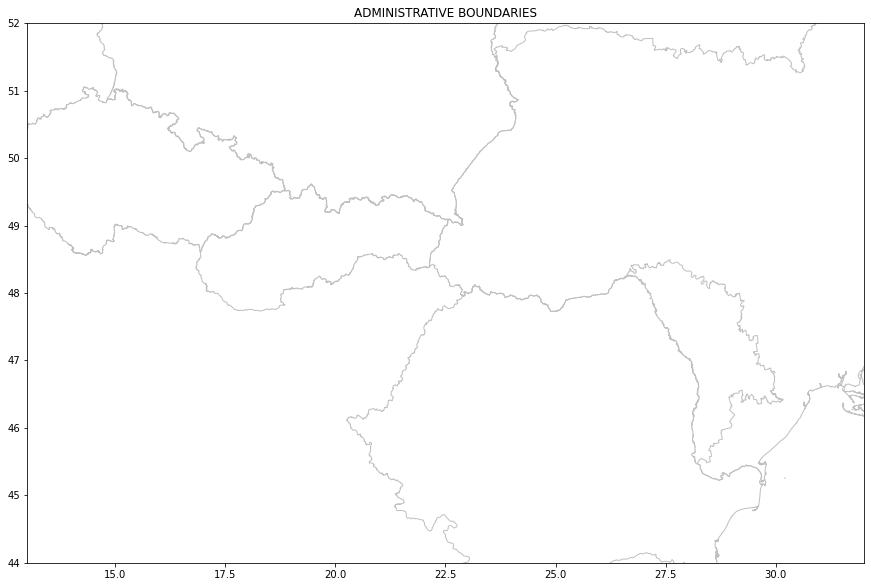

In [10]:
# concatinate all administrative boundaries into one GeoDataFrame
countries_boundaries_df = pd.concat([cze_boundaries_df, pol_boundaries_df, 
                                     svk_boundaries_df, ukr_boundaries_df, 
                                     rou_boundaries_df], 
                                    axis=0)

# visualize coutries' borders
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

set_map_limits()
ax.set_title('ADMINISTRATIVE BOUNDARIES')

plot_countries(ax)

plt.show()

# 1. Forest on the map

In [11]:
# get geometry and other useful information of the ecoregion
terrestrial_ecoregions    = 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/TerrestrialEcoregionsoftheWorld_WWF.geojson'
terrestrial_ecoregions_df = get_df(terrestrial_ecoregions)

forest_df = terrestrial_ecoregions_df[terrestrial_ecoregions_df['ECO_NAME'] ==  'Carpathian montane forests']

In [12]:
def plot_forest(ax, color='none', edgecolor='seagreen', linewidth=3):
  """
  Plots forest's boundaries on the map.
  """
  forest_df.plot(ax=ax, color=color, edgecolor=edgecolor, linewidth=linewidth)

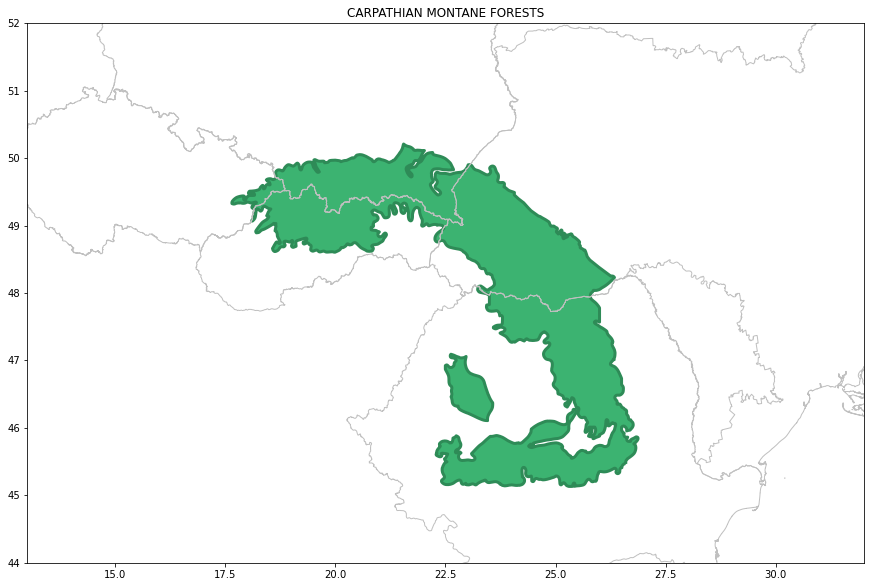

In [13]:
# visualize the forest on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

set_map_limits()
ax.set_title('CARPATHIAN MONTANE FORESTS')

plot_forest(ax, color='mediumseagreen')
plot_countries(ax)

plt.show()

# 2. General Information

Unlabled data can be found here:

https://databasin.org/datasets/68635d7c77f1475f9b6c1d1dbe0a4c4c/layers/cda0991fc9114c6e8eebbaed208ed11b/metadata/original/

In [14]:
area_km2 = forest_df['area_km2'].unique()[0]
realm    = forest_df['REALM_1'].unique()[0]
biome    = forest_df['BIOME'].unique()[0]
gbl_stat = forest_df['GBL_STAT'].unique()[0]

In [15]:
print(f'Area of the Ecoregion: {area_km2} km2',
      f'Biogeographical Realm: {realm}',
      f'Global Status: {gbl_stat}(vulnerable)',
      f'Biome: {biome}(Temperate Conifer Forests)',
      sep='\n')

Area of the Ecoregion: 125335 km2
Biogeographical Realm: Palearctic
Global Status: 2(vulnerable)
Biome: 5(Temperate Conifer Forests)


# 3. Climate Zones

In [16]:
# download climate data
climate    = 'https://datasets.mojaglobal.workers.dev/0:/Climate/IPCC_ClimateZoneMap_Vector.geojson'
climate_df = get_df(climate)

In [17]:
climate_classification = {'1': 'Warm Temperate Moist', '2': 'Warm Temperate Dry', 
                          '3': 'Cool Temperate Moist', '4': 'Cool Temperate Dry', 
                          '5': 'Polar Moist', '6': 'Polar Dry',
                          '7': 'Boreal Moist', '8': 'Boreal Dry',
                          '9': 'Tropical Montane'}

# normalize column's name
climate_df.rename(columns={'CLASS_NAME': 'class_name'}, inplace=True)

# remove oceans
climate_df = climate_df[climate_df.class_name != 0]

# replace classification codes with actual names
climate_df.class_name = climate_df.class_name.astype('str').replace(climate_classification)

# get only necessary data related to forest
forest_climate_df = climate_df.clip(forest_df)

In [18]:
def plot_features(features_df, ax, column, cmap='Set3'):
  """
  Plots some of the forest's features on the map.
  """
  features_df.plot(ax=ax, cmap=cmap, column=column, legend=True)

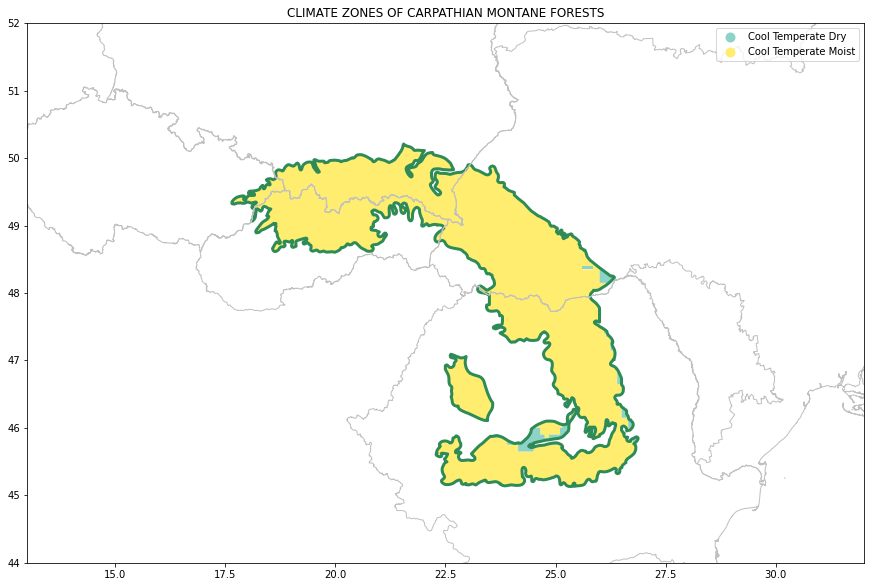

In [19]:
# visualize climate zones on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

set_map_limits()
ax.set_title('CLIMATE ZONES OF CARPATHIAN MONTANE FORESTS')

plot_features(forest_climate_df, ax=ax, column='class_name')
plot_forest(ax=ax)
plot_countries(ax)

plt.show()

# 4. Bioclimatic and Ecologiclal Zones

## 4.1 Agro-ecological Zones

In [20]:
# download agro-ecological zones data
agroeco_zones    = 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/GAEZ_Global_AgroEcological_Zones/GlobalAgroEcologicalZones_GAEZ.geojson'
agroeco_zones_df = get_df(agroeco_zones)

In [21]:
values = {'1': 'Steep terrain', '2': 'Artic/Cold', '3': 'Desert/Arid', 
          '4': 'Irrigated Soils', '5': 'Hydromorphic soils', 
          '6': 'Dry, good soils', '7': 'Dry, moderate soils', '8': 'Dry, poor soils', 
          '9': 'Moist, good soils', '10': 'Moist, moderate soils', 
          '11': 'Moist, poor soils', '12': 'Sub-humid, good soils', 
          '13': 'Sub-humid, moderate soils', '14': 'Sub-humid, poor soils', 
          '15': 'Humid, good soils', '16': 'Humid, moderate soils', 
          '17': 'Humid, poor soils', '18': 'Water'}

# normalize column's name
agroeco_zones_df.rename(columns={'Value': 'value'}, inplace=True)

# replace classification codes with actual names
agroeco_zones_df.value = agroeco_zones_df.value.astype('str').replace(values)

In [22]:
# get only necessary data related to forest
forest_agroeco_zones_df = agroeco_zones_df.clip(forest_df)

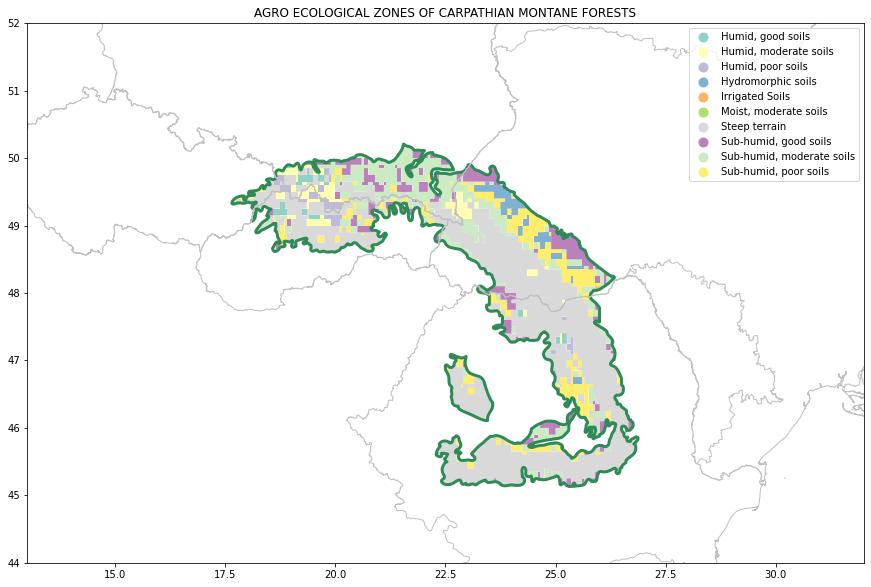

In [23]:
# visualize agro-ecological zones on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title('AGRO ECOLOGICAL ZONES OF CARPATHIAN MONTANE FORESTS')

set_map_limits()
plot_features(forest_agroeco_zones_df, ax=ax, column='value')
plot_forest(ax)
plot_countries(ax)

plt.show()

## 4.2 Ecological Zones

In [24]:
# download ecological zones data
eco_zones    = 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/Global_Ecological_Zone_GEZ/GlobalEcologicalZone_GEZFAO2010.json'
eco_zones_df = get_df(eco_zones)

KeyboardInterrupt: 

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\mi92\miniconda3\envs\carpathians\lib\logging\__init__.py", line 1512, in log
    self._log(level, msg, args, **kwargs)
  File "C:\Users\mi92\miniconda3\envs\carpathians\lib\logging\__init__.py", line 1587, in _log
    record = self.makeRecord(self.name, level, fn, lno, msg, args,
  File "C:\Users\mi92\miniconda3\envs\carpathians\lib\logging\__init__.py", line 1556, in makeRecord
    rv = _logRecordFactory(name, level, fn, lno, msg, args, exc_info, func,
  File "C:\Users\mi92\miniconda3\envs\carpathians\lib\logging\__init__.py", line 316, in __init__
    self.filename = os.path.basename(pathname)
  File "C:\Users\mi92\miniconda3\envs\carpathians\lib\ntpath.py", line 216, in basename
    return split(p)[1]
  File "C:\Users\mi92\miniconda3\envs\carpathians\lib\ntpath.py", line 191, in split
    i -= 1
KeyboardInterrupt: 


In [25]:
# get only necessary data related to forest
ecol_zones_df = eco_zones_df[['gez_name', 'geometry']]
forest_eco_zones_df = eco_zones_df.clip(forest_df)

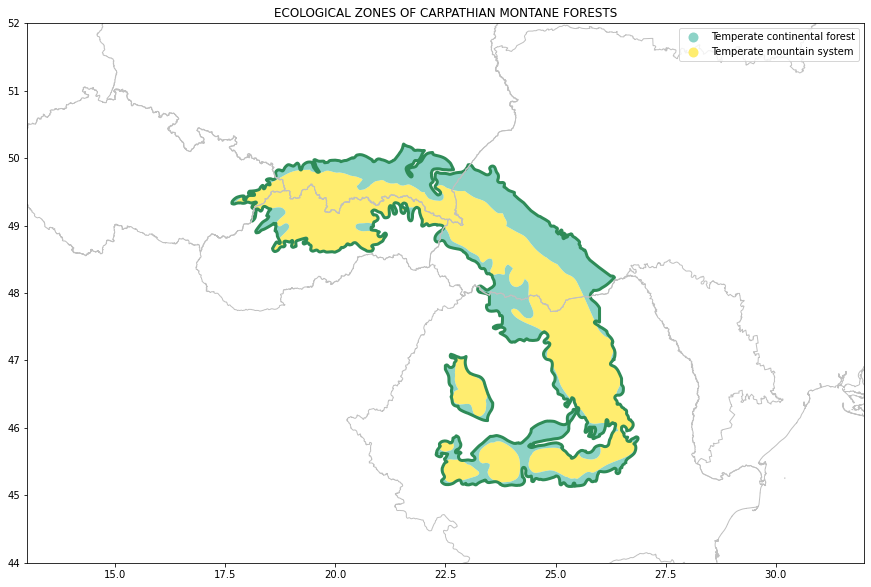

In [26]:
# visualize ecological zones on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title('ECOLOGICAL ZONES OF CARPATHIAN MONTANE FORESTS')
set_map_limits()

plot_features(forest_eco_zones_df, ax=ax, column='gez_name')
plot_forest(ax)
plot_countries(ax)

plt.show()

## 4.3 Holdridge Life Zones

In [27]:
# download holdridge life zones data
holdridge_zones    = 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/HoldridgeLifeZones.json'
holdridge_zones_df = get_df(holdridge_zones)

In [28]:
# normalize column's name
holdridge_zones_df.rename(columns={'DESC': 'desc'}, inplace=True)

In [29]:
# get only necessary data related to forest
holdridge_zones_df = holdridge_zones_df[['desc', 'geometry']]
forest_holdridge_zones_df = holdridge_zones_df.clip(forest_df)

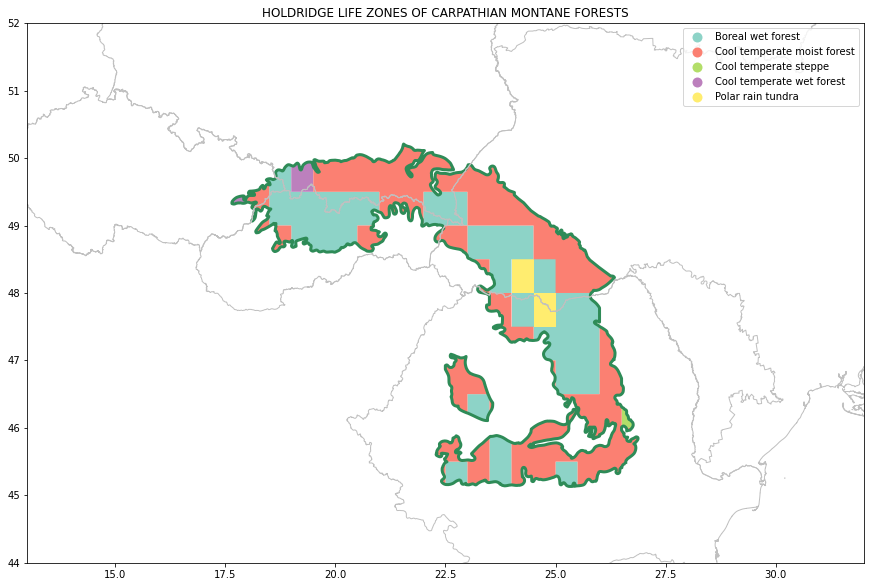

In [30]:
# visualize holdridge life zones on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title('HOLDRIDGE LIFE ZONES OF CARPATHIAN MONTANE FORESTS')
set_map_limits()

plot_features(forest_holdridge_zones_df, ax=ax, column='desc')
plot_forest(ax)
plot_countries(ax)

plt.show()

# 5. Soil Resources

In [31]:
# download soil data
soil    = 'https://datasets.mojaglobal.workers.dev/0:/Soil/World%20Soil%20Resources/World_Soil_Resources_wgs84.geojson'
soil_df = get_df(soil)

In [32]:
# normalize column's name
soil_df.rename(columns={'IPCC': 'ipcc'}, inplace=True)

# get only necessary data related to forest
soil_df = soil_df[['ipcc', 'geometry']]
forest_soil_df = soil_df.clip(forest_df)

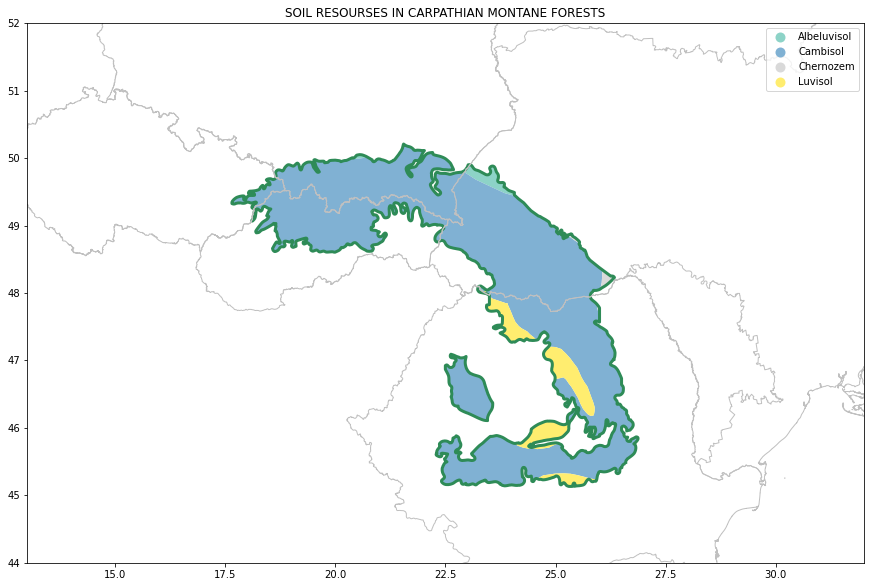

In [33]:
# visualize soil resources on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title('SOIL RESOURSES IN CARPATHIAN MONTANE FORESTS')
set_map_limits()

plot_features(forest_soil_df, ax=ax, column='ipcc')
plot_forest(ax)
plot_countries(ax)

plt.show()

# 6. Forest Cover Change

In [34]:
# ee.Authenticate()
# ee.Initialize()

In [35]:
Map = geemap.Map(center=(48, 22.5), zoom=6)
Map.setOptions('TERRAIN')
gfc = ee.Image('UMD/hansen/global_forest_change_2021_v1_9')

In [36]:
forest_df.geometry

4767    POLYGON ((26.59046 45.47041, 26.59398 45.47595...
7652    POLYGON ((22.77030 47.05305, 22.76003 47.05611...
Name: geometry, dtype: geometry

In [37]:
coords1 = ee.Geometry.Polygon(list(forest_df.geometry[4767].exterior.coords))
coords2 = ee.Geometry.Polygon(list(forest_df.geometry[7652].exterior.coords))

geom = ee.FeatureCollection([coords1, coords2])
gfcClip = gfc.clipToCollection(geom)
Map.addLayer(gfc2014Clip)
Map.addLayer(geom, {'color': 'green'}, 'Multipolygon geometry', False)

In [38]:
treeCover = gfc2014Clip.select(['treecover2000'])
lossImage = gfc2014Clip.select(['loss'])
gainImage = gfc2014Clip.select(['gain'])

# Add the tree cover layer in green.
Map.addLayer(treeCover.updateMask(treeCover),
    {'palette': ['000000', '00FF00'], max: 100}, 'Forest Cover')

# Add the loss layer in red.
Map.addLayer(lossImage.updateMask(lossImage),
            {'palette': ['FF0000']}, 'Loss')

# Add the gain layer in blue.
Map.addLayer(gainImage.updateMask(gainImage),
            {'palette': ['0000FF']}, 'Gain')

In [39]:
# Add legend
legend_keys = ['Forest Cover', 'Loss', 'Gain']
legend_colors = ['004E00', 'FF0000', '0000FF']

Map.add_legend(
    legend_keys=legend_keys, legend_colors=legend_colors, position='bottomleft'
)

In [40]:
Map

Map(center=[48, 22.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…